# Field plays strategically

*Synopsis*: In this notebook, we analyze the case where the *field* plays the optimal strategy evaluated in the "base model" (see, *base_model_notebook.ipynb*). This optimal strategy used by the *field* in every game, is appropriately embedded in $\eta$ and $\rho$, which dictates the outcome of random variables $A$ (*advantage*) and $X_4$ (score difference in the last quarter). Given this use of field's strategy, we re-evaluate the team's best response. The maximization problem is again solved by backward induction over a discretized state space as before.  Next, we discuss its implications on the *Expected Win Rate*  and the *Optimal Strategies*. Simulation results show that the main conclusions from the base model continue to hold.

---

$~$
$~$
$~$
$~$


## 1. Analysis

The analysis closely follows what we have done in the "base model". The optimization problem  is solved computationally. We make specific choices for the previously described probability distributions governing the process. There are some modifications compared to the base model to take into account that the field plays the optimal strategy evaluated in the base model. The exact values are as follows:

- Total number of games, T = 80
- Effort reserve of *field*, $e^F$ $\; \sim \;$ Uniform $(0,1)$ 
- Effort reserve of *team*, $e^P$ $\; \sim \;$ Uniform $(r, 1)$ when saving in previous game is $r$ 
- Maximum absolute score difference in each quarter, $p \;= \;10$.
- Fraction of total effort that the team uses in the first three quarters, $\alpha \;=\; 0.70$
- Field divides available effort reserve equally across all four quarters in every game. Therefore, $\beta = 0.70$.
- Advantage (A) to team at the start of $Q4$ follows a binomial distribution with support $\{-30,-29,... , 0 ,... , 29, 30\}$ :
    - $A \; \sim \; $ Binomial $ \bigg(60, \frac{\alpha e^P}{\alpha e^P+ \beta e^F}\bigg) \; - \; 30$  
- Score-difference in the fourth quarter ($X_4$) given effort exerted by the team in Q4 is $x$,  follows a binomial distribution with support $\{-10, \cdots , 0 , \cdots , 10\}$):   
    - $X_4 \;\sim \;$ Binomial$ \bigg(20, \frac{x}{\;\;x \;+ \;x^* \;\;}\bigg) \; - \; 10 $, $\;\;$ where $x^*$ is the optimal action in $Q4$ evaluated in the base model.
    

The differences from the base model are: (1) the value of $\beta$ now equals $\alpha$, and (2) the probability parameter in the distribution of $X_4$ is different.

$~$
$~$
$~$
$~$
$~$

In [1]:
import numpy as np
from scipy.stats import binom
import math
import matplotlib.pyplot as plt
import time 

In [2]:
                    # ====  STAGE REWARD  ==== #
######     Prob[X_4 > 10 - G], where X_4 follows Binomial(20, e_p / (e_p + e_f))   
######     Input G lies between {-30,....,30}                     


def reward(G, y, x):
    N = 20
    if x == 0.0 and y == 0.0:
        x = 1.0
        y = 1.0
    if G == -10:
        return binom.pmf(20, N, x/(x+y))/2.0
    
    elif G == 10:
        return (1.0 - binom.pmf(0, N, x/(x+y))/2.0 ) ### P(X_4 > 0) + 1/2*P[X_4 = 0]
    
    elif np.isin(G, np.linspace(-9, 9,19)):
        return (1.0 -   binom.cdf(10 - G, N, x/(x+y)) + binom.pmf(10 - G, N, x/(x+y))/2.0) 
    
    elif np.isin(G, np.linspace(-30, -11,20)):
        return 0.0
    else:
        return 1.0
    

In [3]:
######  This function makes Evaluation of Expected Value at t+1 cleaner and faster.                       
######   Takes as INPUT P[:,:,:] and V[t+1, :,:,:] : the value array for period t+1.(used in the Bellman)  
######   OUTPUTS a 2D array.  Dimensions corresponding to E_f and E_p.                                     
######  The (i, j)th cell value is the expected value where the expectation is taken over G.              
######   G follows Bin(60,f(E_p)/(f(E_p)+g(E_f)))                                                          


def expected_value_given_Ef_and_Ep(x,p):
    (g,e_f, e_p) = x.shape
    output = np.zeros((e_f,e_p))
    for i in range(0,e_p):
        for j in range(0,e_f):
            output[j,i] = sum(x[:,j,i]*p[:,j,i])
    return(output)

In [4]:
def team(x,alpha):
    a = alpha
    return(a*x)

In [5]:
def field(x,beta):
    b = beta
    return(beta*x)

In [6]:
def effort(x,y):
    if y == 0:
        return(0)
    else:
        return(x/y)

In [7]:
######  Value Matrix and other array Initialization

T = 80
G = 61
num_of_states_E_f = 100    ###### number of effort_grid_points
num_of_states_E_p = 100   ###### number of effort_grid_points

V = np.zeros((T+2,G,num_of_states_E_f,num_of_states_E_p))  
V_new = np.zeros((T+2,G,num_of_states_E_f,num_of_states_E_p))  

strategy = np.zeros((T+2,G,num_of_states_E_f,num_of_states_E_p))  
strategy_new = np.zeros((T+2,G,num_of_states_E_f,num_of_states_E_p))  
opt_strategy_effort_index = np.zeros((T+2,G,num_of_states_E_f,num_of_states_E_p))  


In [8]:
               #  ====   DISTRIBUTION OF 'G'  ==== #
#######   Recall that, given E_f and  E_p,  'A'  follows the Binomial distribution  and therefore so does 'G' := 'A' + 30.

s_0 = 0.0
s_n = 1.0
alpha = 0.7/3.0 #### team spends 3*alpha*E_p in the first 3quarters. (roughly the same as field per quarter for first 3 Quarters.)
beta = 1/4.0  #### field spends beta*E_f every quarter
beta_new = 0.7/3.0  ## this will be used when the field plays (base model) optimal strategy
E_f = np.linspace(s_0, s_n, num = num_of_states_E_f)
E_p = np.linspace(s_0, s_n, num = num_of_states_E_p)


              


                # ==  PROBABILITY CUBE  == # 
#######   Given E_f and E_p,  P[:,e_f, e_p ]   gives the mass on each value of G.  
#######   This is going to be heavily used everytime while computing the expectation term in the Bellman  

P = np.zeros((G, num_of_states_E_f, num_of_states_E_p)) ## P = np.zeros((G, E_f, E_p))

for i in range(0,len(E_p)):
    i_used = int(np.around(3.0*alpha*i))
    for j in range(0, len(E_f)):
        if i == 0 :
            if j == 0:
                p = 0.5
            else :
                p = 0.0
        else:
            p = E_p[i_used]/(E_p[i_used]+field(E_f[j],3.0*beta))
            
        for g in range(0, 61):
            P[g,j, i] = binom.pmf(g, 60, p)

In [9]:
            # ====  EVALUATION OF VALUE IN GAME 'T'  ==== #

for i in range(0,len(E_p)):
    for j in range(0,len(E_f)):
        for g in range(0, 61):
            V[T,g,j,i] = reward((g-30),(beta)*E_f[j], (1.0 - 3.0*alpha)*E_p[i])  

##### Field spends 3*beta*E_f in first 3Q and beta*E_f in the Q4. 
##### Team spends everything in the last quarter since V_T+1 = 0.

#### Maximization problem when the field is not strategic.
The optimal strategy evaluated here will later be played by the field. 

In [3]:
              #====  Backward Induction   ====#

#####  This code block solves the same maximization problem as the one solved in the "base model".
    
    
for t in range(T-1,0,-1):
#     print (time.ctime(), " t = ",t)
    expected_value_over_G = expected_value_given_Ef_and_Ep( V[t+1,:,:,:], P )   ## Expectation over G : the function returns a 2D array. cell (j,i) denotes expected value given E_f[j], E_p[i]  
    for i in range(0,len(E_p)):
        loc_available_Q4 = int(i - np.around(3.0*alpha*i))
        for j in range(0, len(E_f)):
            for g in range(0, 61):                  
                Y = np.zeros(loc_available_Q4 + 1)
                for i_hat in range(0,loc_available_Q4 +1):       # i_hat loops over available effort grid
                    Y[i_hat] = reward(g-30,field(E_f[j],beta),E_p[i_hat]) + (expected_value_over_G[:, (loc_available_Q4 - i_hat):].sum())*(1/len(E_f))*(1/len(E_p[(loc_available_Q4 - i_hat):]))
                V[t,g,j,i] = np.max(Y)
                opt_strategy_effort_index[t,g,j,i] = np.argmax(Y)
                strategy[t,g,j,i] = E_p[np.argmax(Y)]
                                   


$~$
$~$
$~$
$~$
$~$
$~$
$~$
$~$
$~$


## Field Plays Optimal Strategy

In [12]:
                # ==  NEW PROBABILITY CUBE  == # 
#######   Given E_f and E_p,  P_new[:,e_f, e_p ]   gives the mass on each value of G.  
#######   This is going to be heavily used everytime while computing the expectation term in the Bellman  


P_new = np.zeros((G, num_of_states_E_f, num_of_states_E_p)) ## P = np.zeros((G, E_f, E_p))

for i in range(0,len(E_p)):
    i_used = int(np.around(3.0*alpha*i))
    for j in range(0, len(E_f)):
        j_used = int(np.around(3.0*beta_new*j))
        if i == 0 :
            if j == 0:
                p = 0.5
            else :
                p = 0.0
        else:
#             p = float(team(E_p[i],alpha)/(team(E_p[i],alpha)+field(E_f[j],beta_new)))
            p = float(E_p[i_used]/(E_p[i_used]+E_f[j_used]))
            
        for g in range(0, 61):
            P_new[g,j, i] = binom.pmf(g, 60, p)

In [13]:
         # ====  EVALUATION OF 'NEW' VALUE IN GAME 'T'  ==== #
    
for i in range(0,len(E_p)):
    for j in range(0,len(E_f)):
        for g in range(0, 61):
            V_new[T,g,j,i] = reward((g-30),(1.0 - 3.0*beta_new)*E_f[j], (1.0 - 3.0*alpha)*E_p[i])
            

##### Field spends 0.7*E_f in first 3Q and 0.3*E_f in the Q4. 
##### Team spends everything in the last quarter since V_T+1 = 0.

$~$
$~$
$~$

---
### Backward Induction  (Bellman)

---

In [2]:
######## Field Plays Optimal Strategy evaluated in the previous maximisation problem.
                        
for t in range(T-1,0,-1):
#     print (time.ctime(), " t = ",t)
    
    ## Expectation over G : the function returns a 2D array. cell (j,i) denotes expected value given E_f[j], E_p[i]  
    expected_value_over_G = expected_value_given_Ef_and_Ep( V_new[t+1,:,:,:], P_new )   
    for i in range(0,len(E_p)):
        loc_available_Q4 = int(i - np.around(3.0*alpha*i))
        for j in range(0, len(E_f)):
            loc_available_Q4_field = int(j - np.around(3.0*beta_new*j))
            for g in range(0, 61):
                field_strategy_effort_index = int(opt_strategy_effort_index[t,60-g,i,j])  
                #### opt_strategy_effort_index comes from the earlier optimization problem.
                Y = np.zeros(loc_available_Q4 + 1)
                for i_hat in range(0,loc_available_Q4 +1):       # i_hat loops over available effort grid
                    Y[i_hat] = reward(g-30, E_f[field_strategy_effort_index], E_p[i_hat]) + (expected_value_over_G[:, (loc_available_Q4 - i_hat):].sum())*(1/len(E_f))*(1/len(E_p[(loc_available_Q4 - i_hat):]))
                V_new[t,g,j,i] = np.max(Y)
                strategy_new[t,g,j,i] = E_p[np.argmax(Y)]
                   
print('\n Voila!')  


 Voila!


---
$~$
$~$
$~$
$~$
$~$
$~$
$~$
$~$
$~$

$~$
$~$

##  Visualizing results


In [15]:
from numpy import *
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [18]:
##### Helper function to be used in the visualizations  #####
def my_surface_plot(axis, x, y, z, label_to_use):
    c = axis.plot_surface(x, y, z, label=label_to_use)
    c._facecolors2d=c._facecolors3d
    c._edgecolors2d=c._edgecolors3d
    return 

$~$
$~$
$~$
$~$

### *Expected Win Rate (EWR)*
##### For games 10 through to 70
---
For every state $s \in S$, the Expected Win Rate ($EWR$) in games remaining at period $t$ is given by the expression $\frac{V_t(s)}{T - t +1}$. 

In the figure below, we visualize EWR at three different **advantage** scenarios: 
- The team is **ahead** at the start of Q4, i.e., the score-difference is in favour of the team.
- The scores are **even** at the start of Q4.
- The team is **behind** at the start of Q4, i.e., the score-difference is in favour of the field.



<IPython.core.display.Javascript object>


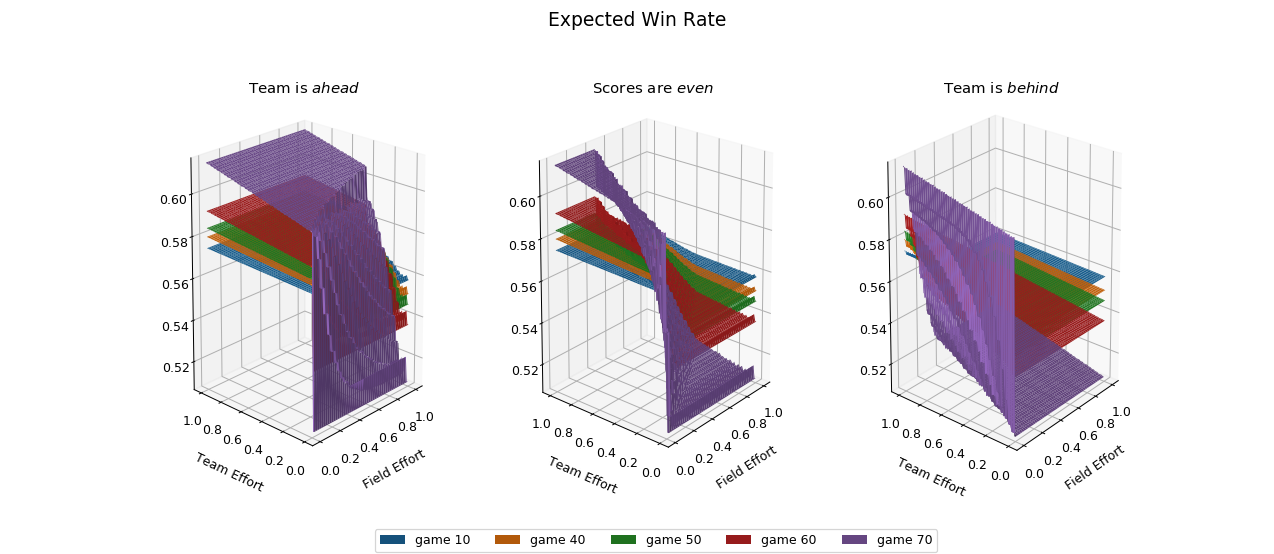

In [19]:
games = [10, 40, 50, 60, 70]   ## Array consisting of the games to be plotted. A game correspond to the variable 't' in the model.
adv_ahead , adv_even, adv_behind = 37, 30, 23     ## three advantage scenarios

x,y = mgrid[0:len(E_p), 0:len(E_p)]  ###### Effort meshgrid  ######
fig = plt.figure()

## Advantage: AHEAD
axis_ahead = fig.add_subplot(131,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
axis_ahead.set_title('Team is $ahead$')
for game in games:
    EWR = V_new[game,adv_ahead,x,y]/(T - game +1)
    my_surface_plot(axis_ahead, E_f[x], E_p[y], EWR, "t = {}".format(game))

## Advantage: EVEN
axis_even = fig.add_subplot(132,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    EWR = V_new[game,adv_even,x,y]/(T - game +1)
    my_surface_plot(axis_even, E_f[x], E_p[y], EWR, "game {}".format(game))
axis_even.set_title('Scores are $even$')
axis_even.legend(ncol=5, bbox_to_anchor=(1.5, -0.07),  loc = 'best')

## Advantage: BEHIND
axis_behind = fig.add_subplot(133,projection='3d', xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    EWR = V_new[game,adv_behind,x,y]/(T - game +1)
    my_surface_plot(axis_behind, E_f[x], E_p[y], EWR, "t = {}".format(game))
axis_behind.set_title('Team is $behind$')

fig.suptitle('Expected Win Rate', fontsize=15)

plt.show()


**Remarks:**
-  The range of EWR shrinks as we go earlier in the season, highlighting the  insensitivity of initial conditions in a long season. 
- If the team is well *ahead* or *behind* at the start of $Q4$, the strength difference between the teams does not lead to a drastic change in $EWR$; except in the case when, either the team or the field starts with a very low reserve (close to zero). It is rather the time in the season that matters more. The value of being ahead (resp., behind) at the start of $Q4$, increases (resp., decreases) when there are fewer games remaining.
- If scores are *even* at the start of $Q4$, the strength difference between the teams plays a role in determining EWR. Starting the game as the relatively stronger team is more valuable when there are fewer games remaining. On the other hand, the value of  starting as the relatively weaker team gets increasingly worse as one proceeds through the season.
    
   

$~$
$~$
$~$
$~$


$~$
$~$
$~$

###    *Optimal Strategy (effort_usage at Q4)*
##### For games 10 through to 70

From the optimal strategy obtained from the solution of the maximization problem above, we visualize below the **optimal effort usage in Q4** of the *team* as a function of its own effort level and the *field*'s effort level, for three different **advantage** scenarios that the team may find itself at the start of $Q4$: 
- The team is **ahead** at the start of Q4, i.e., the score-difference is in favour of the team.
- The scores are **even** at the start of Q4.
- The team is **behind** at the start of Q4, i.e., the score-difference is in favour of the field.

Note that the range of the $z-axis$ is up to $0.30$. This is because the team has spent $\alpha e^P$ ($\alpha = 0.70$) in the first three quarters.

<IPython.core.display.Javascript object>


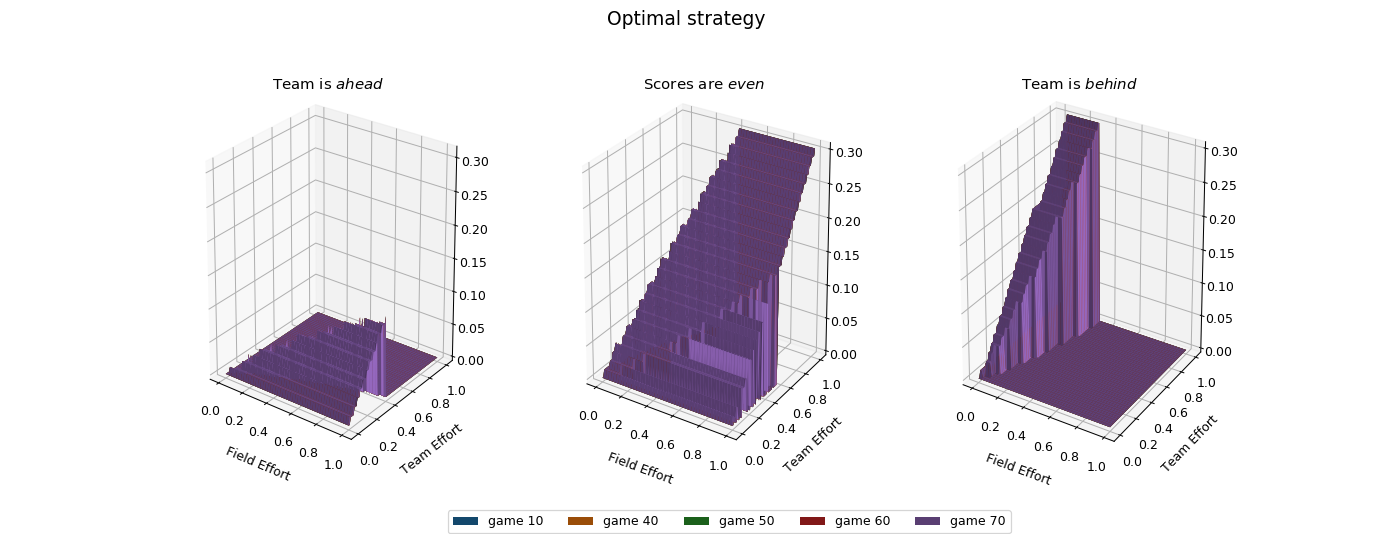

In [21]:
games = [10, 40, 50, 60, 70]   ## Array consisting of the games to be plotted. A game correspond to the variable 't' in the model.
adv_ahead , adv_even, adv_behind = 37, 30, 23     ## three advantage scenarios

x,y = mgrid[0:len(E_p), 0:len(E_p)]  ###### Effort meshgrid  ######
fig = plt.figure()

## Advantage: AHEAD
axis_ahead = fig.add_subplot(131,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
axis_ahead.set_title('Team is $ahead$')
for game in games:
    opt_strategy = strategy_new[game,adv_ahead,x,y]
    my_surface_plot(axis_ahead, E_f[x], E_p[y], opt_strategy, "t = {}".format(game))
axis_ahead.set_zlim3d(0.0,0.31)

## Advantage: EVEN
axis_even = fig.add_subplot(132,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    opt_strategy = strategy_new[game,adv_even,x,y]
    my_surface_plot(axis_even, E_f[x], E_p[y], opt_strategy, "game {}".format(game))
axis_even.set_title('Scores are $even$')
axis_even.legend(ncol=5, bbox_to_anchor=(1.5, -0.07),  loc = 'best')

## Advantage: BEHIND
axis_behind = fig.add_subplot(133,projection='3d', xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    opt_strategy = strategy_new[game,adv_behind,x,y]
    my_surface_plot(axis_behind, E_f[x], E_p[y], opt_strategy, "t = {}".format(game))
axis_behind.set_title('Team is $behind$')

fig.suptitle('Optimal strategy', fontsize=15)

plt.show()

**Remarks:**

- Firstly, one can observe from the figure that the optimal strategy is highly insensitive to the stage in the season.
- When the *advantage* at the start of $Q4$  is well in favour of the team, but the team starts with a very low initial energy reserve, it optimal to use up the remaining energy against a relatively very  strong opponent. However, for all other starting energy scenarios, good advantage always calls for saving energy in $Q4$ (there is a sharp drop to zero). 
- If the scores are level at the start of $Q4$ and the relative strength is strongly in favour of the team (i.e., field starts with energy reserve close to zero); we see from the figure that it is indeed then optimal to save energy for future games. If the  team starts the game very low on energy, there are occasional spikes  of energy utilization in $Q4$, even when the  team faces a relatively strong opponent.
- If the score-difference is largely in favour of the opponent after $Q3$, unless the opponent starts the game very weak (energy close to zero) compared to the team, it is always optimal to save all remaining energy in $Q4$ (there is a sharp drop to zero). 

$~$
$~$
$~$


$~$
$~$
$~$

## End Season
Below we focus attention to the last five games  in the season in which, future games must be taken into consideration (i.e., **game 75 through to 79**). Recall that the league ends after game $t = T = 80$, and thus the team does not need to save for future games and uses up all the remaining energy $(1-\alpha)e_{80}^P$ in Q4 of game *80*. By **last five games**, we will henceforth refer to the following five games: $t$  = $75, 76, 77, 78, 79$.

### *Expected Win Rate (EWR)*
##### For games 75 through to 79

<IPython.core.display.Javascript object>


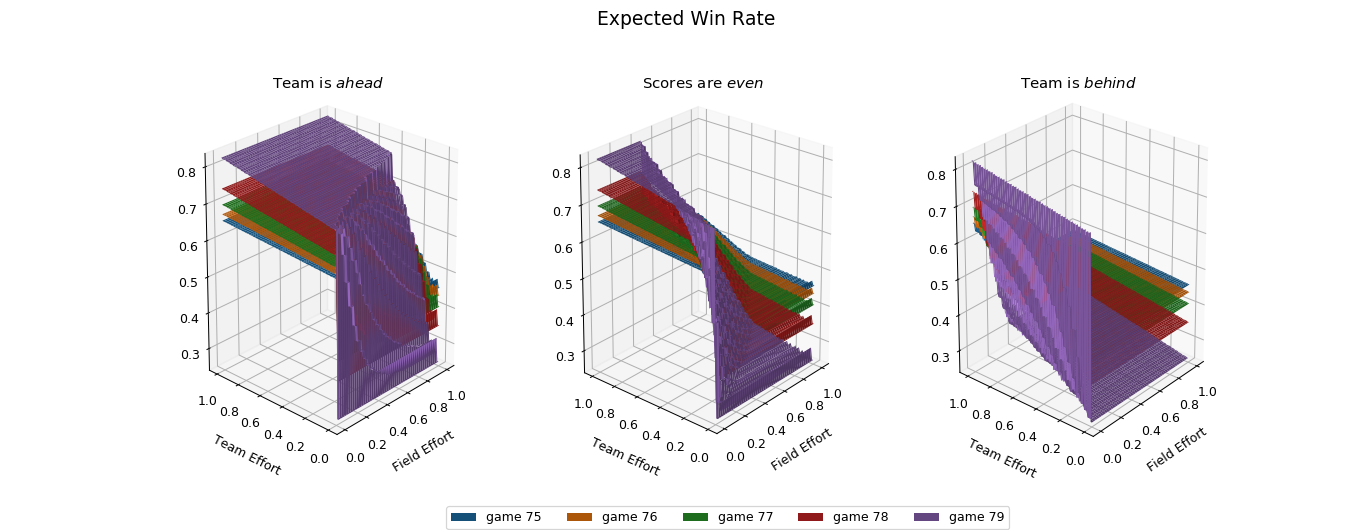

In [22]:
games = [75, 76, 77, 78, 79]   ## Array consisting of the games to be plotted. A game correspond to the variable 't' in the model.
adv_ahead , adv_even, adv_behind = 37, 30, 23     ## three advantage scenarios

x,y = mgrid[0:len(E_p), 0:len(E_p)]  ###### Effort meshgrid  ######
fig = plt.figure()

## Advantage: AHEAD
axis_ahead = fig.add_subplot(131,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
axis_ahead.set_title('Team is $ahead$')
for game in games:
    EWR = V_new[game,adv_ahead,x,y]/(T - game +1)
    my_surface_plot(axis_ahead, E_f[x], E_p[y], EWR, "t = {}".format(game))

## Advantage: EVEN
axis_even = fig.add_subplot(132,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    EWR = V_new[game,adv_even,x,y]/(T - game +1)
    my_surface_plot(axis_even, E_f[x], E_p[y], EWR, "game {}".format(game))
axis_even.set_title('Scores are $even$')
axis_even.legend(ncol=5, bbox_to_anchor=(1.5, -0.07),  loc = 'best')

## Advantage: BEHIND
axis_behind = fig.add_subplot(133,projection='3d', xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    EWR = V_new[game,adv_behind,x,y]/(T - game +1)
    my_surface_plot(axis_behind, E_f[x], E_p[y], EWR, "t = {}".format(game))
axis_behind.set_title('Team is $behind$')

fig.suptitle('Expected Win Rate', fontsize=15)

plt.show()

**Remark:**

- There is a very large variation in the values of $EWR$ when compared to games earlier in the season.
- If the team is well *ahead* or well *behind* at the start of $Q4$, the  strength difference between the teams does not affect EWR; except when, either the team or the field starts with a very low reserve (close to zero). The value of being *ahead* (resp.,  *behind*) at the start of $Q4$ is quite  high (resp., low); and increases (resp., decreases) further as one proceeds to the very end of the season.
- If scores are *even* at the start of $Q4$, the strength difference between the teams plays a key role in determining EWR. Starting the game as the relatively stronger team is more valuable when there are fewer games remaining. However, the value of starting as the relatively weaker team gets increasingly worse as we head to the very end of the season.

$~$
$~$
$~$

###    *Optimal Strategy (effort_usage at Q4)*
##### For games 75 through to 79

<IPython.core.display.Javascript object>


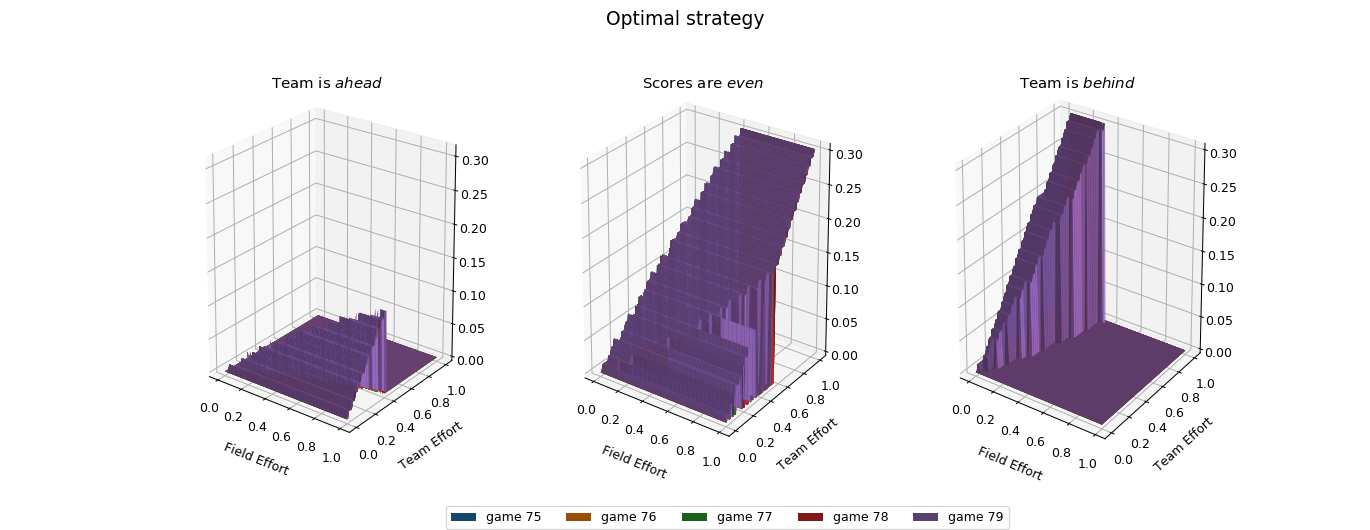

In [23]:
games = [75, 76, 77, 78, 79]   ## Array consisting of the games to be plotted. A game correspond to the variable 't' in the model.
adv_ahead , adv_even, adv_behind = 37, 30, 23     ## three advantage scenarios

x,y = mgrid[0:len(E_p), 0:len(E_p)]  ###### Effort meshgrid  ######
fig = plt.figure()

## Advantage: AHEAD
axis_ahead = fig.add_subplot(131,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
axis_ahead.set_title('Team is $ahead$')
for game in games:
    opt_strategy = strategy_new[game,adv_ahead,x,y]
    my_surface_plot(axis_ahead, E_f[x], E_p[y], opt_strategy, "t = {}".format(game))
axis_ahead.set_zlim3d(0.0,0.31)

## Advantage: EVEN
axis_even = fig.add_subplot(132,projection='3d',xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    opt_strategy = strategy_new[game,adv_even,x,y]
    my_surface_plot(axis_even, E_f[x], E_p[y], opt_strategy, "game {}".format(game))
axis_even.set_title('Scores are $even$')
axis_even.legend(ncol=5, bbox_to_anchor=(1.5, -0.07),  loc = 'best')

## Advantage: BEHIND
axis_behind = fig.add_subplot(133,projection='3d', xlabel="\nField Effort", ylabel="\nTeam Effort")
for game in games:
    opt_strategy = strategy_new[game,adv_behind,x,y]
    my_surface_plot(axis_behind, E_f[x], E_p[y], opt_strategy, "t = {}".format(game))
axis_behind.set_title('Team is $behind$')

fig.suptitle('Optimal strategy', fontsize=15)

plt.show()

**Remark:**

- The optimal strategy is quite insensitive to which game we consider even towards the very end of the season.
- Saving energy in $Q4$ is indeed optimal in a variety of situations, similar to what we observed for games earlier in the season. 
